# Diversity Condition Violated Correct Model

This is a notebook that performs the experiment when the diversity condition is violated and we select a correct model to adjust for that.

- $p(\tilde{z}|z) = \delta(u - u') \frac{e^{\kappa}\tilde{z}^{T}z}{\int_{W(z)}e^{\kappa z^{T}z'}dz'}$ - model conditional density
- $q_{h}(\tilde{z}|z) = \delta(u-u') \frac{e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z)}}{\int_{W(z)}e^{\frac{1}{\tau}h(z)^{T}h(z')}dz'}$ - Model conditional density

The loss function in this setup will be the following:

$\mathcal{L} = \mathbb{E}_{(z, \tilde{z}) \sim p(z, \tilde{z}), \{z^{-}_{i}\} \sim U(\mathcal{W}(z)) }[- \log(\frac{e^{\frac{1}{\tau}h(\tilde{z})^{T}h(z)}}{\Sigma_{i=1}^{M}e^{\frac{1}{\tau} h(\tilde{z})^{T}h(z^{-}_{i})}})]$

The plan is to do the experiments with the following data generating processess:

- 

In [15]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
from torch import functional

from spaces import NSphereSpace
from visualization_utils.spheres import visualize_spheres_side_by_side
import matplotlib.pyplot as plt
from evals.disentanglement import linear_disentanglement, permutation_disentanglement
from visualization_utils.scoring import plot_scores

full_sphere = NSphereSpace(3)
sub_sphere = NSphereSpace(2)

class SimCLRAdjusted(nn.Module):
    def __init__(self, d, d_fix, neg_samples, decoder, encoder, sample_pair, sample_negative, tau=0.1, device=None):
        super(SimCLRAdjusted, self).__init__()
        self.d = d
        self.d_fix = d_fix
        self.neg_samples = neg_samples
        self.tau = tau
        self.decoder = decoder
        self.encoder = encoder
        self.sample_pair = sample_pair
        self.sample_negative = sample_negative
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.decoder.to(self.device)
        self.encoder.to(self.device)

    def loss(self, Z_enc, Z_pos_enc, Z_neg_enc):
        neg = torch.logsumexp((Z_enc.unsqueeze(1) * Z_neg_enc).sum(dim=2) / self.tau, dim=1).mean()
        pos = - (Z_enc * Z_pos_enc).sum(dim=1).mean() / self.tau

        return neg + pos, neg, pos

    def train(self, batch_size, iterations):
        for p in self.decoder.parameters():
            p.requires_grad = False

        adam = torch.optim.Adam(self.encoder.parameters(), lr=1e-4)

        h = lambda latent: self.encoder(self.decoder(latent.to(self.device)))

        # --- Evaluation on latent space before training
        control_latent, _ = self.sample_pair(batch_size)
        control_latent = control_latent.to(self.device)

        linear = linear_disentanglement(control_latent, control_latent)
        print("Linear control score:", linear[0][0])

        perm = permutation_disentanglement(control_latent, control_latent)
        print("Permutation control score:", perm[0][0])

        linear_scores = []
        perm_scores = []

        for i in range(iterations):
            z, z_sim = self.sample_pair(batch_size)

            z = z.to(self.device)
            z_sim = z_sim.to(self.device)

            z_neg = self.sample_negative(z, self.neg_samples).to(self.device)
            z_enc = h(z)
            z_enc_sim = h(z_sim)
            z_enc_neg = h(z_neg)

            loss_result, neg, pos = self.loss(z_enc, z_enc_sim, z_enc_neg)

            loss_result.backward()
            adam.step()
            

            if i % 20 == 1:
                lin_dis, _ = linear_disentanglement(z.cpu(), z_enc.cpu())
                lin_score, _ = lin_dis

                perm_dis, _ = permutation_disentanglement(z.cpu(), z_enc.cpu())
                perm_score, _ = perm_dis

                linear_scores.append(lin_score)
                perm_scores.append(perm_score)

                print('Loss:', loss_result.item(), 'Samples processed:', i,
                      "linear disentanglement:", lin_score,
                      'permutation disentanglement:', perm_score,
                      'Negative:', neg.item(),
                      'Positive:', pos.item())
                
        self.encoder.eval()

        return self.encoder, {'linear_scores': linear_scores, 'perm_scores': perm_scores}

d_fix = 1
d = 3
kappa = 8
tau = 1 / kappa
batch_size = 2000
neg_samples = batch_size * 1
iterations = 2000

# Sampling negative samples in the case where the model of the latent space has violated diversity condition, but our model adjusts for that
def sample_negative_samples(Z, M):
    z_fixed = Z[:, :d_fix].to(device)

    radii = torch.sqrt(1 - (z_fixed ** 2).sum(dim=1)).to(device)  # Radius of the sub-sphere
    neg_samples = torch.randn(Z.shape[0], M, d - d_fix, device=device)

    neg_samples = neg_samples / (neg_samples.norm(dim=2, keepdim=True) + 1e-8)  # Normalize the samples + add some margin for error
    neg_samples = neg_samples * radii.view(-1, 1, 1)

    return torch.cat((z_fixed.unsqueeze(1).expand(-1, M, -1), neg_samples), dim=2)


def sample_conditional_with_dims_fixed(z, batch, u_dim):
    u = z[:, :u_dim].to(device)
    v = z[:, u_dim:].to(device)

    v_norm = torch.nn.functional.normalize(v, dim=-1, p=2).to(device)
    aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, batch).to(device) * torch.norm(v, p=2, dim=-1, keepdim=True).to(device)

    return torch.cat((u, aug_samples_v), dim=-1)


def sample_pair_with_fixed_dimension(batch, u_dim):
    z = full_sphere.uniform(batch).to(device)  # (N, 3)
    
    return z, sample_conditional_with_dims_fixed(z, batch, u_dim)

sample_pair_fixed = lambda batch: sample_pair_with_fixed_dimension(batch, d_fix)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using device:", device)

torch.cuda.empty_cache()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Visualizing the sampling processess

- Uniform Sampling
- Conditional Sampling
- Negative sample sampling

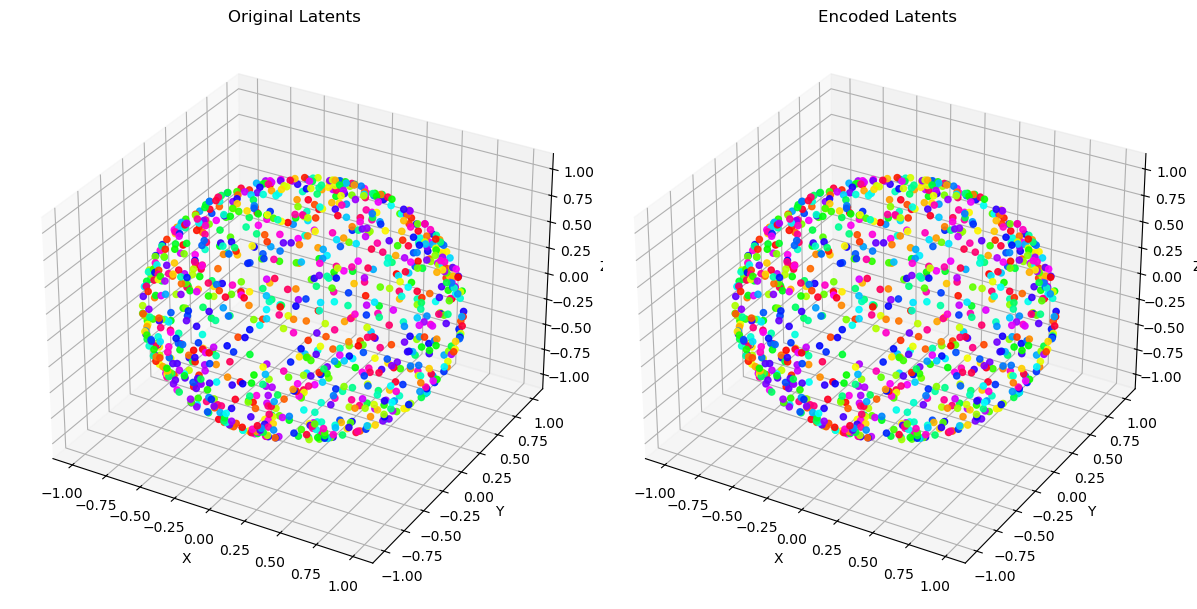

In [11]:
## Uniform sampling

s = full_sphere.uniform(1000)

visualize_spheres_side_by_side(plt, s, s)

tensor([0.3411, 0.7370, 0.5835])


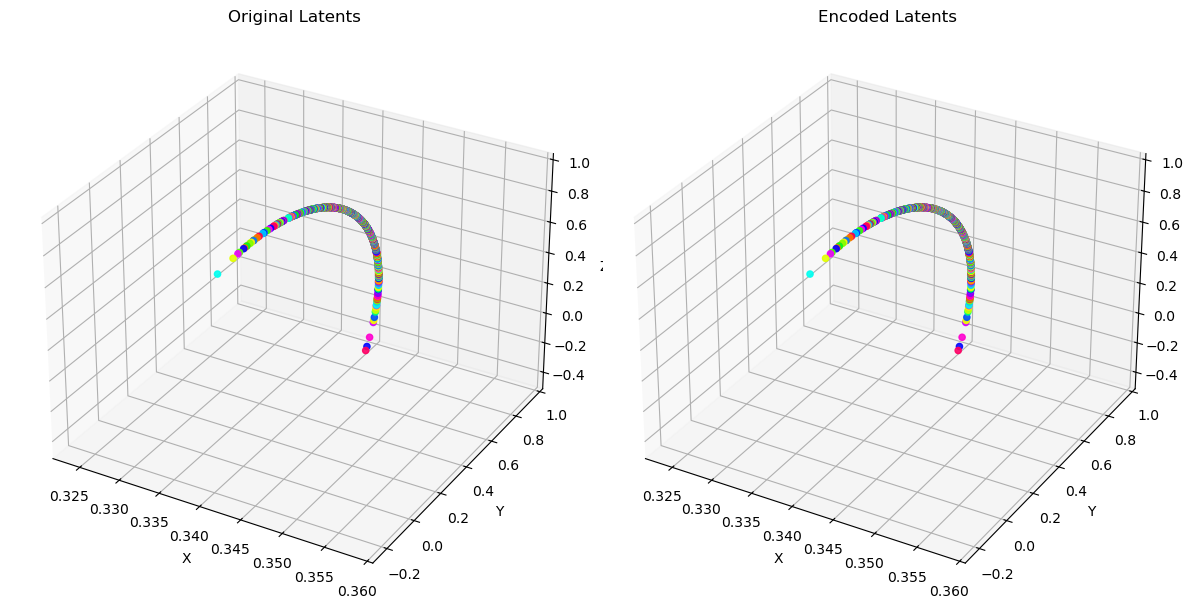

In [12]:
## Visualizing similar sample sampling

z = full_sphere.uniform(1).squeeze(0)

print(z)

u = z[:1]
v = z[1:]

v_norm = torch.nn.functional.normalize(v, dim=-1, p=2)
aug_samples_v = sub_sphere.von_mises_fisher(v_norm, kappa, 1000) * torch.norm(v, p=2, dim=-1, keepdim=True)

z_aug = torch.cat((u.expand(1000, 1), aug_samples_v), dim=-1)

visualize_spheres_side_by_side(plt, z_aug, z_aug)

z shape: tensor([[-0.7937, -0.0872, -0.6020]])
SHAPE OF NEGATIVE SAMPLES torch.Size([1000, 3])
MAX tensor(1.0000, device='cuda:0')
MIN tensor(1.0000, device='cuda:0')


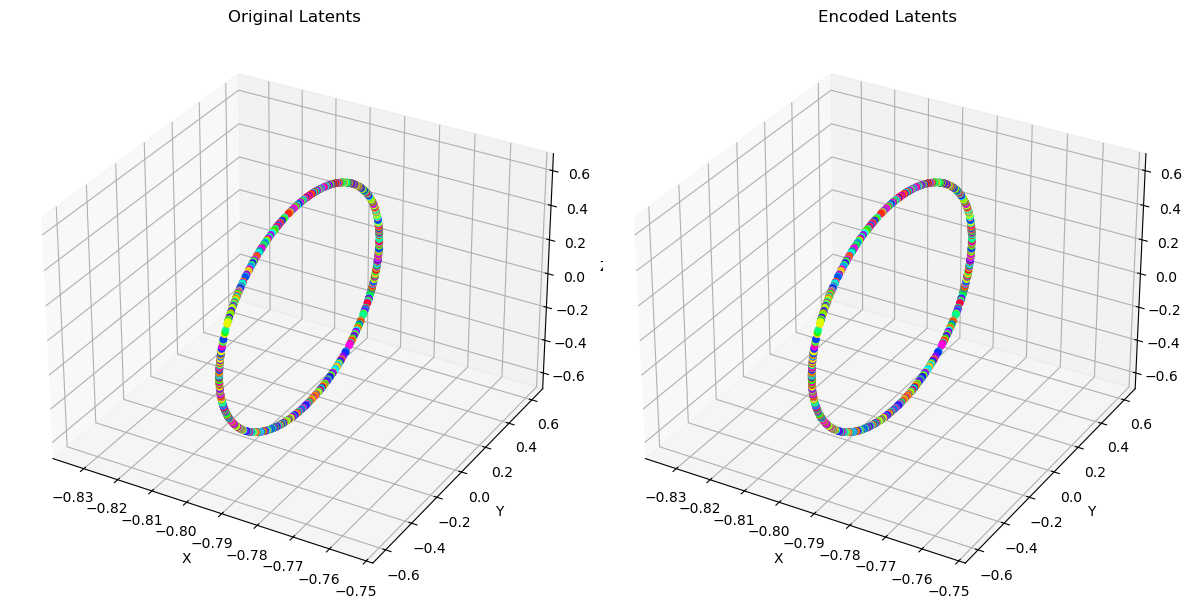

In [13]:
## Visualizing the negative sample sampling

z = full_sphere.uniform(1)

print("z shape:", z)

negative_samples = sample_negative_samples(z, 1000).squeeze(0)

print('SHAPE OF NEGATIVE SAMPLES', negative_samples.shape)
print("MAX", (negative_samples ** 2).sum(dim=1).max())
print("MIN", (negative_samples ** 2).sum(dim=1).min())

visualize_spheres_side_by_side(plt, negative_samples, negative_samples)

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.600237846374512 Samples processed: 1 linear disentanglement: 0.46064135432243347 permutation disentanglement: -7.063150405883789e-05 Negative: 15.60017204284668 Positive: -7.999934196472168
Loss: 7.566854000091553 Samples processed: 21 linear disentanglement: 0.4952363967895508 permutation disentanglement: 0.0317014642059803 Negative: 15.564537048339844 Positive: -7.997683048248291
Loss: 7.25480318069458 Samples processed: 41 linear disentanglement: 0.5873487591743469 permutation disentanglement: 0.11524812132120132 Negative: 15.205731391906738 Positive: -7.950928211212158
Loss: 7.091744422912598 Samples processed: 61 linear disentanglement: 0.5436200499534607 permutation disentanglement: 0.18407690525054932 Negative: 14.667375564575195 Positive: -7.575631141662598
Loss: 6.980271816253662 Samples processed: 81 linear disentanglement: 0.583818256855011 permutation disentanglement: 0.19798411428928375 Negative: 14.516375541

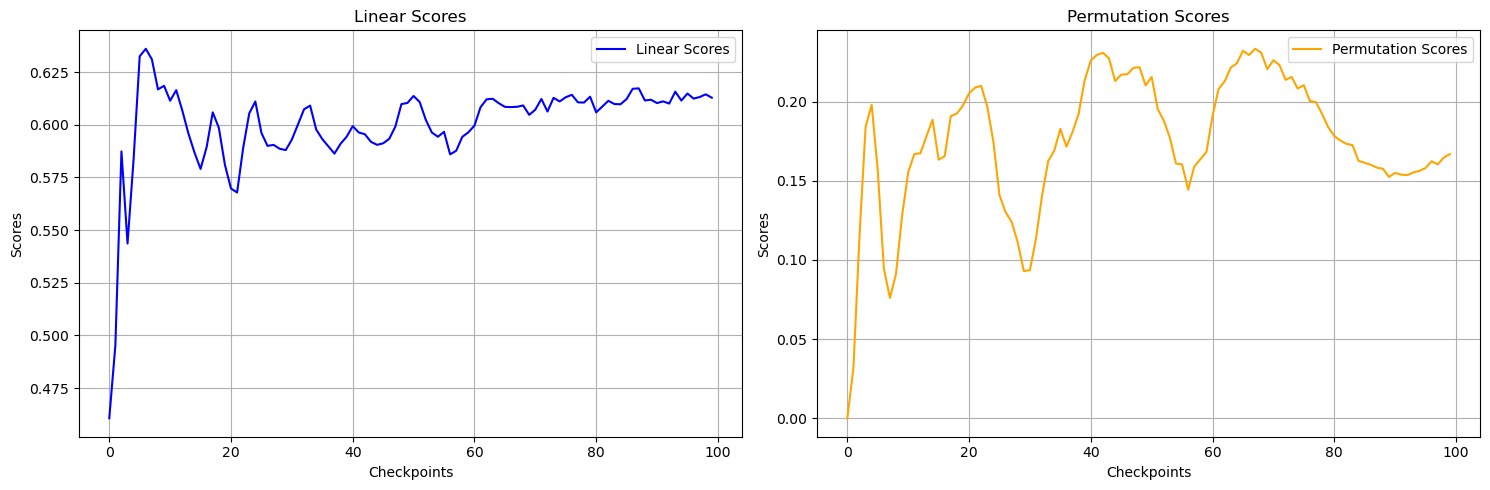

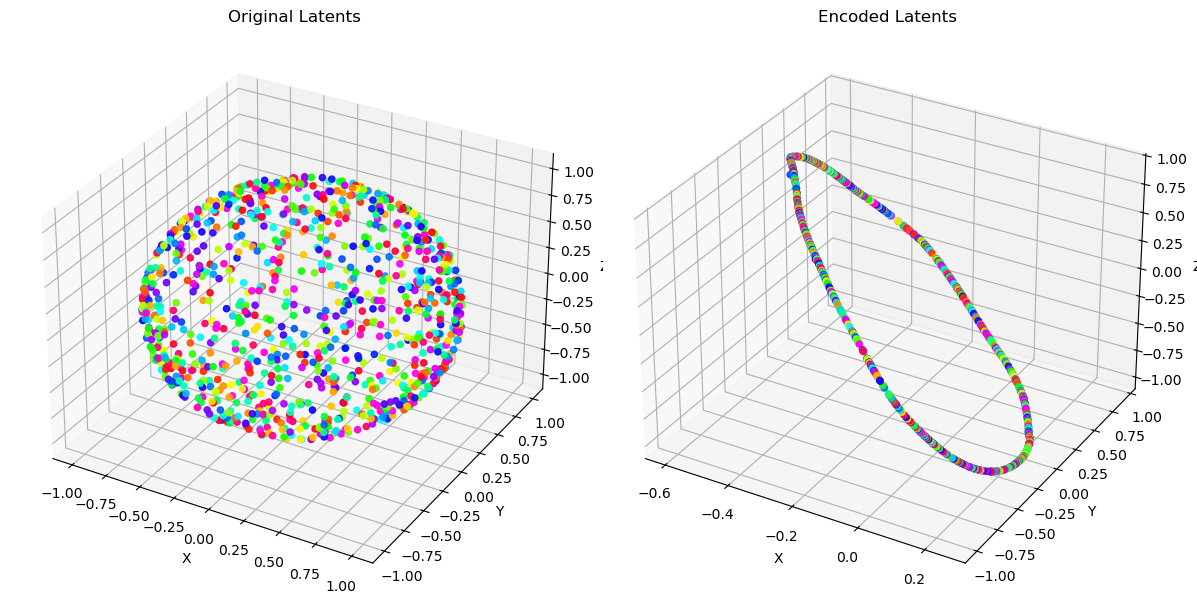

In [16]:
from encoders import get_mlp

# Initialize the multi-layer perceptron used for encoding
f_constrained_id = get_mlp(
    n_in=3,
    n_out=3,
    layers=[
        3 * 10,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 50,
        3 * 10,
    ],
    output_normalization="fixed_sphere",
).to("cpu")

g_id = nn.Identity()

sim_clr_identity = SimCLRAdjusted(
    d=d,
    d_fix=d_fix,
    neg_samples=neg_samples,
    decoder=g_id,
    encoder=f_constrained_id,
    sample_pair=sample_pair_fixed,
    sample_negative=sample_negative_samples,
    tau=tau,
    device=device
)

f_constrained_id, scores = sim_clr_identity.train(
    batch_size=batch_size,
    iterations=iterations,
)

torch.cuda.empty_cache()

plot_scores(plt, scores)

h_constrained = lambda z: f_constrained_id(g_id(z))

z = full_sphere.uniform(1000).to(device)
z_enc = h_constrained(z).to(device)

visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

In [ ]:
from data.generation import InjectiveLinearDecoder
from encoders import construct_mlp_encoder

def perform_linear_experiment(data_dim):
    g_linear = InjectiveLinearDecoder(3, data_dim)
    f = construct_mlp_encoder(data_dim, 3)

    sim_clr_4d = SimCLRAdjusted(
        d=d,
        d_fix=d_fix,
        neg_samples=neg_samples,
        decoder=g_linear,
        encoder=f,
        sample_pair=sample_pair_fixed,
        sample_negative=sample_negative_samples,
        tau=tau,
        device=device
    )

    f, scores = sim_clr_4d.train(
        batch_size=batch_size,
        iterations=iterations,
    )
    torch.cuda.empty_cache()

    plot_scores(plt, scores)

    h = lambda z: f(g_linear(z))
    z = full_sphere.uniform(1000).to(device)
    z_enc = h(z)

    visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())


Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.599437236785889 Samples processed: 1 linear disentanglement: 0.5796770453453064 permutation disentanglement: -0.00019025802612304688 Negative: 12.599264144897461 Positive: -4.999826908111572
Loss: 7.183011531829834 Samples processed: 251 linear disentanglement: 0.3280281126499176 permutation disentanglement: 0.17607562243938446 Negative: 11.623902320861816 Positive: -4.440890789031982
Loss: 7.258663177490234 Samples processed: 501 linear disentanglement: 0.33541741967201233 permutation disentanglement: 0.15544457733631134 Negative: 11.62319564819336 Positive: -4.364532470703125
Loss: 7.197936534881592 Samples processed: 751 linear disentanglement: 0.30728065967559814 permutation disentanglement: 0.2320682257413864 Negative: 11.591358184814453 Positive: -4.393421649932861
Loss: 7.07072114944458 Samples processed: 1001 linear disentanglement: 0.33363160490989685 permutation disentanglement: 0.16516809165477753 Negative: 11.

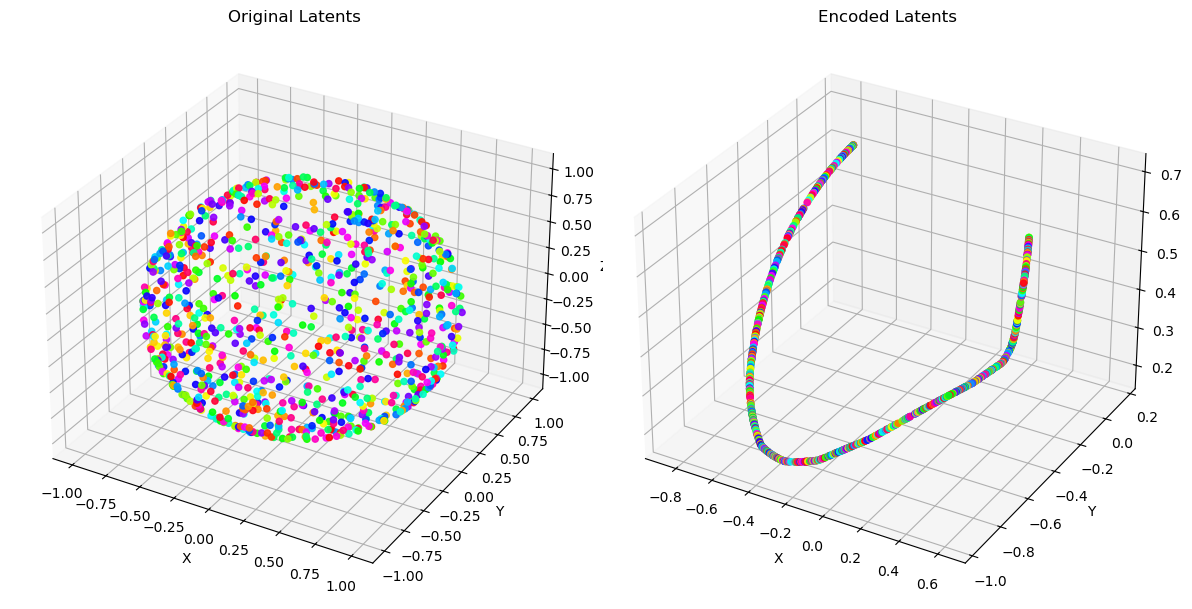

In [4]:
torch.cuda.empty_cache()
perform_linear_experiment(4)

Linear control score: 1.0
Permutation control score: 1.0
Loss: 7.600423336029053 Samples processed: 1 linear disentanglement: 0.4339376389980316 permutation disentanglement: 0.0005464355344884098 Negative: 12.600316047668457 Positive: -4.999892711639404
Loss: 6.5976738929748535 Samples processed: 251 linear disentanglement: 0.596571147441864 permutation disentanglement: 0.5658695697784424 Negative: 11.038137435913086 Positive: -4.440463542938232
Loss: 6.742494583129883 Samples processed: 501 linear disentanglement: 0.581506073474884 permutation disentanglement: 0.5453986525535583 Negative: 11.063644409179688 Positive: -4.321149826049805
Loss: 6.611962795257568 Samples processed: 751 linear disentanglement: 0.5885081887245178 permutation disentanglement: 0.5630999803543091 Negative: 10.985149383544922 Positive: -4.3731865882873535
Loss: 6.585887908935547 Samples processed: 1001 linear disentanglement: 0.5927385687828064 permutation disentanglement: 0.49410536885261536 Negative: 11.04979

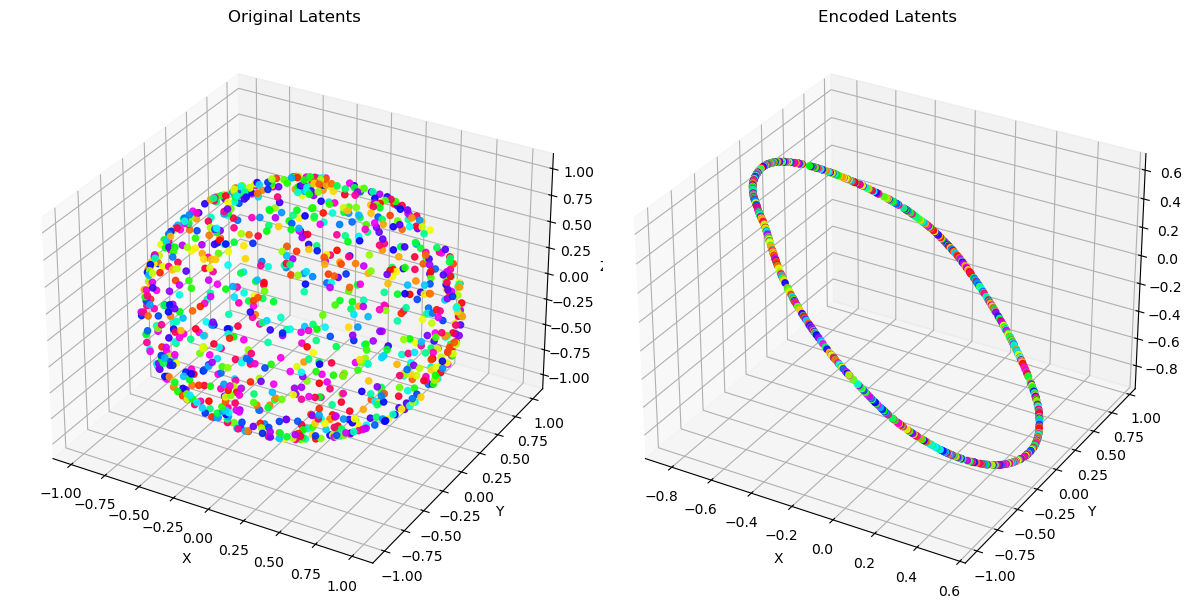

In [5]:
perform_linear_experiment(5)

In [6]:
perform_linear_experiment(6)

Linear control score: 1.0
Permutation control score: 1.0


RuntimeError: CUDA out of memory. Tried to allocate 4.47 GiB (GPU 0; 47.40 GiB total capacity; 38.67 GiB already allocated; 2.12 GiB free; 43.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF